## Example of 2D periodic problem

Create the grid for the unit circle.

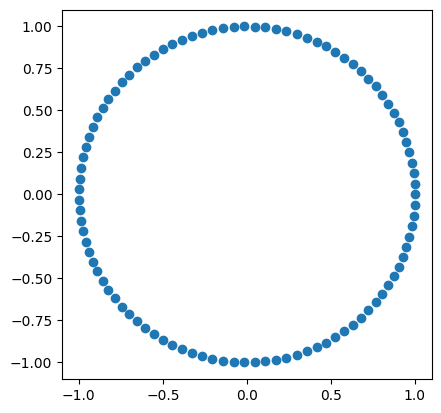

In [1]:
# change directory to the root of the project
from os import chdir

chdir("../")

import numpy as np
from pypbem.utils.twoD.circle_grid import get_circle_grid

grid = get_circle_grid(0.01)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(grid[:, 0], grid[:, 1])
ax.set_aspect("equal")
plt.show()

Set parameters

In [2]:
d = 4
k = 4 * 2 / d
theta = 0
beta = k * np.sin(theta)
point = np.array([0 * d, 0.01 * d])

M = 100

Assemble the left and right hand side, by evaluating the single layer boundary operator.

In [3]:
from pypbem.utils.twoD.BSLO import assemble_BSLO
from pypbem.utils.twoD.RHS import assemble_RHS


BSLO = assemble_BSLO(grid, d, k, beta, 2)
RHS = assemble_RHS(grid, d, k)

Solve the system with GMRES.

In [4]:
from scipy.sparse.linalg import gmres

alpha, info = gmres(BSLO, RHS)

Evaluate the single layer potential operator and get the total field in [-10, 10] × [-d/2,d/2]

In [5]:
Nx = 100
Ny = 20
xlim = 10
xmin, xmax, ymin, ymax = [-xlim, xlim, -d / 2, d / 2]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]
points = np.vstack((plot_grid[0].ravel(), plot_grid[1].ravel()))
u_evaluated = np.zeros(points.shape[1], dtype=np.complex128)
u_evaluated[:] = np.nan

x, y = points
idx_ext = np.sqrt(x**2 + y**2) > 1
idx_int = np.sqrt(x**2 + y**2) <= 1

points_exterior = points[:, idx_ext]
points_interior = points[:, idx_int]

from pypbem.utils.twoD.potential import potential_eval

field_ext = np.zeros((points_exterior.shape[1],), dtype=np.complex64)
for i in range(points_exterior.shape[1]):
    y = points_exterior[:, i]
    field_ext[i,] = potential_eval(y, grid, alpha, d, k, beta, 2)

u_evaluated[idx_ext] = (-field_ext + np.exp(1j * k * points_exterior[0,])).flat
u_evaluated[idx_int] = np.zeros((points_interior.shape[1],))
u_evaluated = u_evaluated.reshape([Nx, Ny])

Plot the real total field.

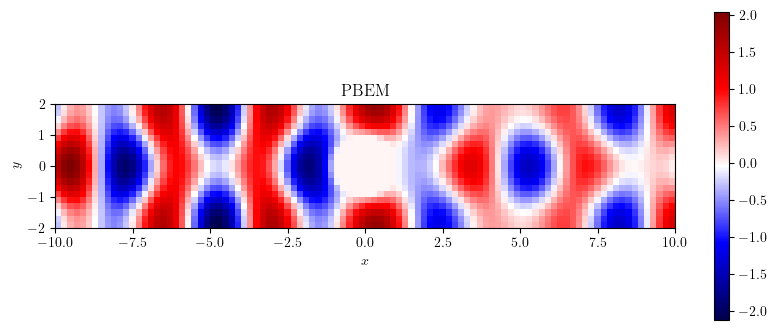

In [6]:
%matplotlib inline
from matplotlib import pylab as plt
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({"text.usetex": True, "font.family": "serif"})
fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(111)
pos = ax.imshow(np.real(u_evaluated.T), extent=[-xlim, xlim, -d / 2, d / 2], cmap="seismic")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_title("PBEM")
plt.colorbar(pos, ax=ax)
plt.show()